# 核心模块 Core Module

> 主要定义与任务相关的核心组件和配置
> 
> Defines core components and configurations related to tasks

## 简介/Description: 

核心模块包含任务相关的主要类和配置文件，如 ClassificationTask 和 ClassificationTaskConfig。其中配置文件通过 Pydantic 进行定义，帮助用户更好地构建图像分类任务的各个部分。

The core module contains the primary classes and configuration files related to tasks, such as ClassificationTask and ClassificationTaskConfig, where the configurations are defined using Pydantic, allowing users to easily structure components of image classification tasks.

## 主要符号/Main symbols:

- ClassificationTask: 用于处理图像分类任务的 PyTorch Lightning 模块。
- ClassificationTask: A PyTorch Lightning module for handling image classification tasks.
- ClassificationTaskConfig: 使用 Pydantic 设计的配置类，用于初始化任务。
- ClassificationTaskConfig: A configuration class designed with Pydantic for initializing the task.


In [1]:
#| default_exp nucleus

In [2]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [3]:
#| export
import os
os.environ['HF_ENDPOINT'] = "https://hf-mirror.com" # TODO this is optional for Foreigners

In [4]:
from transformers import AutoModel, AutoConfig, ViTModel, ViTConfig
from namable_classify.infra import print_model_pretty
AutoModel.from_pretrained("google/vit-base-patch16-224-in21k").training

[2024-12-03 01:48:41,138] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/ycm/home_program_files/miniconda3/envs/fastai/bin/../lib/gcc/x86_64-conda-linux-gnu/14.1.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/ycm/home_program_files/miniconda3/envs/fastai/bin/../lib/gcc/x86_64-conda-linux-gnu/14.1.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


False

In [5]:
#| export
from pydantic import BaseModel
class ClassificationModelConfig(BaseModel):
    provider: str = "huggingface"
    checkpoint: str = "google/vit-base-patch16-224-in21k" # TODO 支持 hf  timm torch
    head_strategy: str = "linear"
    num_of_classes: int = -1
    
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoModel, AutoConfig, ViTModel, ViTConfig
from transformers import AutoImageProcessor, BitImageProcessor, ViTImageProcessor
from deepspeed.ops.adam import DeepSpeedCPUAdam

class HuggingfaceModel(nn.Module):
    """Some Information about HuggingfaceModel"""
    def __init__(self, config : ClassificationModelConfig, forward_with_hf_image_preprocessor=False):
        super().__init__()
        # self.image_preprocessor = BitImageProcessor.from_pretrained(config.model_checkpoint, use_fast=True)
        self.image_preprocessor = AutoImageProcessor.from_pretrained(config.checkpoint)
        self.backbone: ViTModel = AutoModel.from_pretrained(config.checkpoint) # TODO we now just consider ViTModel
        self.backbone.train()
        self.backbone_config: ViTConfig = self.backbone.config # 包括了 image_size 和 hidden_size 这两个重要信息
        if config.head_strategy == "linear":
            self.head = nn.Linear(self.backbone_config.hidden_size, config.num_of_classes)
        else:
            raise NotImplementedError("Only linear head is supported for now. ")
        self.config = config
        self.forward_with_hf_image_preprocessor = forward_with_hf_image_preprocessor
        # 虽然huggingface的dummy inputs很多都是假的不是真的能测试这个模型，但是OpenDelta很矫情，还是认为要有。
        self.dummy_inputs = self.backbone.dummy_inputs
        
    
    
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        if self.forward_with_hf_image_preprocessor:
            x = self.image_preprocessor(images=x, return_tensors="pt")["pixel_values"]
        hf_output = self.backbone(x)
        # hidden_state = hf_output.last_hidden_state
        output = hf_output.pooler_output
        output = self.head(output)
        return output
    
from fastcore.basics import patch
@patch
def get_cls_model(self:ClassificationModelConfig):
    if self.provider == "huggingface":
        return HuggingfaceModel(self)
    else:
        raise NotImplementedError("Only huggingface is supported for now. ")

In [6]:
#| export
import lightning as L
from pydantic import BaseModel
from namable_classify.data import ClassificationDataConfig, ClassificationDataModule

class ClassificationTaskConfig(BaseModel):
    experiment_project: str = "NamableClassify Development" # 为了发表什么论文，正在探索什么IDEA？
    experiment_task: str = "Development Test" # 为了证明我的IDEA有效，正在做哪个数据集、哪个架构的实验？
    experiment_index: int = 0  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 表示是第几次重复实验 # which is also the random seed
    label_smoothing: float = 0.1
    cls_model_config: ClassificationModelConfig = ClassificationModelConfig()
    dataset_config: ClassificationDataConfig = ClassificationDataConfig()
    learning_rate: float = 3e-4
    yuequ:str = "full_finetune"
    yuequ_pe:float = 0.0

In [7]:
#| export
@patch
def see_params_norm(self:nn.Module)->float:
    params = torch.cat([param.view(-1) for param in self.parameters()])
    # 计算范数，这里以2-范数为例
    norm = torch.norm(params, p=2)
    return norm.item()

@patch
def see_grad_norm(self:nn.Module)-> float:
    grads = torch.cat([param.grad.view(-1) for param in self.parameters() if param.grad is not None])
    # 计算范数，这里以2-范数为例
    norm = torch.norm(grads, p=2)
    return norm.item()
    

In [8]:
#| export
from lightning.pytorch import loggers as pl_loggers
from namable_classify.help import runs_path

In [9]:
logger = pl_loggers.TensorBoardLogger(runs_path/"test")
logger.experiment # .experiment 得到的是第三方平台的类型。
# dir(logger) # pl的logger类型方法少很多

In [10]:
#| export
import lightning as L
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS, STEP_OUTPUT, OptimizerLRScheduler
from overrides import override
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from deepspeed.ops.adam import DeepSpeedCPUAdam, FusedAdam 
from deepspeed.ops.lamb import FusedLamb

from namable_classify.infra import print_model_pretty
from namable_classify.infra import append_dict_list, ensure_array, logger
from namable_classify.metrics import compute_classification_metrics, draw_classification_metrics
import numpy as np
from typing import Any, Optional
class ClassificationTask(L.LightningModule):
    def __init__(self, config: ClassificationTaskConfig)->None:
        super().__init__()
        self.save_hyperparameters(config.model_dump())
        L.seed_everything(config.experiment_index) # use index as the seed for reproducibility
        # 首先数据是可以加载的
        self.lit_data:ClassificationDataModule = config.dataset_config.get_lightning_data_module()
        # 数据怎么做Transform，取决于 Model的情况
        # 现在我们加载Model，刚才有了数据之后，首先可以更新 cls_model_config
        
        config.cls_model_config.num_of_classes = self.lit_data.num_of_classes
        self.cls_model:HuggingfaceModel = config.cls_model_config.get_cls_model()
        
        # 现在需要更新数据
        model_image_size:tuple[int, int] = self.lit_data.set_transform_from_hf_image_preprocessor(hf_image_preprocessor=self.cls_model.image_preprocessor)
        
        # model_image_size:tuple[int, int] = (self.cls_model.image_preprocessor.size['height'], self.cls_model.image_preprocessor.size['width'])
        self.example_input_array = torch.randn((1, self.cls_model.backbone.config.num_channels, 
                                                *model_image_size), requires_grad=True)
        self.dummy_inputs = dict(input_ids=self.example_input_array) # for opendelta and huggingface
        # self.dummy_inputs_is_correct = True # Used for boguan_yuequ (博观约取) 's auto opendelta 
        # 最后是训练策略
        # self.softmax = nn.Softmax(dim=1)    
        self.softmax = nn.Identity()
        self.loss = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
        # nn.LogSoftmax(dim=1)
        # https://blog.csdn.net/qq_43391414/article/details/118421352 logsoftmax+nll的速度快，但是没有label smoothing
        
        # 评价策略
        self.evaluation_steps_outputs = dict()
        
        # self.automatic_optimization = False
        self.automatic_optimization = True
        
        # 上面初始化后config有变化，所以需要重新保存一下。
        self.save_hyperparameters(config.model_dump())
        
        # 之前的loss
        self.previous_loss:Optional[float] = None
        
        # 参数高效微调，只会加载部分参数。 https://lightning.ai/docs/pytorch/stable/common/checkpointing_intermediate.html#resume-from-a-partial-checkpoint
        self.strict_loading = False
        
    def state_dict(self):
        # TODO 不稳定的API
        # Only save parameters that require gradients
        return {k: v for k, v in super().state_dict().items() if v.requires_grad}
    
    # @override
    # def on_train_start(self) -> None:
    #     # 更新一下最终的超参数
    #     # self.save_hyperparameters(self.hparams)
    #     # self.lit_data.save_hyperparameters(self.lit_data.hparams)
    #     return super().on_train_start()
    
    def compute_model_logits(self, image_tensor:torch.Tensor)-> torch.Tensor:
        return self.cls_model(image_tensor)
    
    @override
    def forward(self, image_tensor:torch.Tensor, *args, **kwargs)-> torch.Tensor:
        return self.softmax(self.compute_model_logits(image_tensor))

    def forward_loss(self, image_tensor: torch.Tensor, label_tensor:torch.Tensor)->torch.Tensor:
        probs = self(image_tensor)
        # return F.nll_loss(logits, label_tensor)
        return self.loss(probs, label_tensor)

    @override
    def training_step(self, batch, batch_idx=None, *args, **kwargs)-> STEP_OUTPUT:
        # self.train() # 不必要
        # opt = self.optimizers(use_pl_optimizer=False)
        # opt = self.optimizers(use_pl_optimizer=True)
        # opt.zero_grad()
        
        loss = self.forward_loss(*batch)
        self.log("train_loss", loss, prog_bar=True)
        if self.previous_loss is not None:
            self.log("train_loss_delta", float(loss) - self.previous_loss, prog_bar=True)
        self.previous_loss = float(loss)
        # print("Loss:", loss.item())
        # self.manual_backward(loss)
        # loss.backward()
        # self.log("grad_norm", self.see_grad_norm(), prog_bar=True)
        # old_params_norm = self.see_params_norm()
        
        # self.log("params_norm", old_params_norm, prog_bar=True)
        
        # # print("Grad Norm:", self.see_grad_norm())
        # # print("Params Norm before step:", self.see_params_norm())
        # # print("Params of cls_model Norm before step:", self.cls_model.see_params_norm())
        # opt.step()
        # # print("Params Norm after step:", self.see_params_norm())
        # # print("Params of cls_model Norm after step:", self.cls_model.see_params_norm())
        # params_norm_delta = self.see_params_norm() - old_params_norm
        # self.log("params_norm_delta", params_norm_delta, prog_bar=True)
        
        
        
        # sch = self.lr_schedulers()
        # self.log("lr", sch.get_last_lr()[0], prog_bar=True)
        # # https://www.restack.io/p/pytorch-lightning-answer-get-current-training-step-cat-ai
        # # https://github.com/Lightning-AI/pytorch-lightning/pull/11599
        # sch.step(self.global_step/self.trainer.estimated_stepping_batches/self.trainer.max_epochs)
        
        # self.log("global_step", self.global_step, prog_bar=True)
        # # self.log("epoch", self.current_epoch, prog_bar=True)
        # self.log("stepping_batches_of_one_epoch", self.trainer.estimated_stepping_batches/self.trainer.max_epochs, prog_bar=True)
        
        # print()
        # print(loss)
        return loss


    @override    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        # return torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate)
        # return torch.optim.SGD(self.cls_model.parameters(), lr=self.hparams.learning_rate)
        # print("Learning Rate:", self.hparams.learning_rate)
        # return torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        # return torch.optim.AdamW(self.cls_model.parameters(), lr=self.hparams.learning_rate)
        
        # optimizer = optim.SGD(self.cls_model.parameters(), lr=self.hparams.learning_rate)
        # print(len(list(self.parameters())))
        
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()),
                                lr=self.hparams.learning_rate)
        # optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        # optimizer = FusedLamb(self.parameters(), lr=self.hparams.learning_rate)
        # optimizer = DeepSpeedCPUAdam(self.parameters(), lr=self.hparams.learning_rate)
        # optimizer = FusedAdam(self.parameters(), lr=self.hparams.learning_rate)
        # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=self.hparams.learning_rate/10, 
        #                                               max_lr=self.hparams.learning_rate)
        # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html
        # https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling#9.CosineAnnealingWarmRestarts
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        # return ([optimizer], [scheduler])
        return optimizer
        # return ([optimizer], [{"scheduler": scheduler, "interval": "step"}])
        # return L.AdamW(self.parameters(), lr=self.learning_rate)

    # 现在我们已经定义好Training的逻辑了，已经可以跑训练了。然而，除了训练之外，我们需要评测模型的性能。
    # @override
    # def 
    def on_evaluation_epoch_start(self, stage:str=""):
        self.evaluation_steps_outputs = dict()
        self.evaluation_steps_outputs[f'{stage}_batch_probs'] = []
        self.evaluation_steps_outputs[f'{stage}_label_tensor'] = []
            
    def evaluation_step(self, batch, batch_idx=None, stage:str="", *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image_tensor, label_tensor = batch
        batch_probs = self(image_tensor)
        append_dict_list(self.evaluation_steps_outputs, f'{stage}_batch_probs', ensure_array(batch_probs))
        append_dict_list(self.evaluation_steps_outputs, f'{stage}_label_tensor', ensure_array(label_tensor))
        batch_loss = self.loss(batch_probs, label_tensor)
        self.log(f"{stage}_loss", batch_loss, prog_bar=True)
        return batch_loss
            
    def on_evaluation_epoch_end(self, stage:str=""):
        # https://github.com/Lightning-AI/pytorch-lightning/discussions/9845
        # labels = self.lit_data.classes
        labels = list(range(self.lit_data.num_of_classes))
        # labels = None
        # print(labels)
        # stack 是 new axis， concat是existing axis
        all_pred_probs = np.concatenate(self.evaluation_steps_outputs[f'{stage}_batch_probs'])
        all_label_tensor = np.concatenate(self.evaluation_steps_outputs[f'{stage}_label_tensor'])
        # logger.debug(self.evaluation_steps_outputs[f'{stage}_label_tensor'])
        # logger.debug(all_label_tensor)
        eval_dict = compute_classification_metrics(all_label_tensor, all_pred_probs, 
                                                #    logits_to_prob=False, 
                                                   logits_to_prob=True, 
                                                labels=labels)
        eval_dict = {f"{stage}_{k}": v for k,v in eval_dict.items()}
        self.log_dict(eval_dict)
        # tensorboard 可视化
        # draw_classification_metrics
        figures, figure_names = draw_classification_metrics(all_label_tensor, all_pred_probs, 
                                              logits_to_prob=True, 
                                                labels=labels)
        # TODO: bug
        # tb_logger = self.get_logger_with_type(pl_loggers.TensorBoardLogger).experiment
        tb_logger = self.trainer.loggers[0].experiment
        for fig, name in zip(figures, figure_names):
            tb_logger.add_figure(f"{stage}/{name}", fig, self.global_step)
        # tb_logger.add_pr_curve(f"{stage}/pr_curve", all_label_tensor, all_pred_probs, self.global_step)
        
        
        self.evaluation_steps_outputs.clear()
        
    def get_logger_with_type(self, t:type = pl_loggers.TensorBoardLogger)->pl_loggers.Logger:
        # Get tensorboard logger
        target_logger = None
        for logger in self.trainer.loggers:
            if isinstance(logger, t):
                target_logger = logger
                break
        return target_logger

    @override
    def on_validation_epoch_start(self):
        return self.on_evaluation_epoch_start(stage="val")
    
    @override
    def on_test_epoch_start(self):
        return self.on_evaluation_epoch_start(stage="test")

    @override
    def on_validation_epoch_end(self):
        return self.on_evaluation_epoch_end(stage="val")

    @override
    def on_test_epoch_end(self):
        return self.on_evaluation_epoch_end(stage="test")

    @override
    def validation_step(self, batch, batch_idx=None, *args, **kwargs):
        return self.evaluation_step(batch, batch_idx, stage="val")

    @override
    def test_step(self, batch, batch_idx=None, *args, **kwargs):
        return self.evaluation_step(batch, batch_idx, stage="test")


In [11]:
config = ClassificationTaskConfig(
    # learning_rate=1e-3,
    learning_rate=3e-4,
    # learning_rate=1,
    # learning_rate=1e9,
    label_smoothing=0,
)
config
cls_task = ClassificationTask(config)
cls_task.print_model_pretty()
cls_task.print_trainable_parameters()

INFO: Seed set to 0


Tue 2024-12-03 01:49:15.416953

INFO     Seed set to 0                                                                                   ]8;id=225948;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py\seed.py]8;;\:]8;id=371786;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py#54\54]8;;\

/home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Tue 2024-12-03 01:49:16.492410

INFO     ╭──────────────────────────── Model Tree for ClassificationTask ─────────────────────────────╮ ]8;id=271493;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py\torch.py]8;;\:]8;id=536110;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py#72\72]8;;\
         │ root                                                                                       │            
         │ └── cls_model (HuggingfaceModel)                                                           │            
         │     ├── backbone (ViTModel)                                                                │            
         │     │   ├── embeddings (ViTEmbeddings) cls_token:[1, 1, 768] position_embeddings:[1, 197,  │            
         │     │   │   768]                                                                           │            
         │     │   │   └── patch_embeddings (ViTPatchEmbeddings)                                      │            
         │     │   │       └── projection (Conv2d) weight:[768, 3, 16, 16] bias:[768]                 │            
         │     │   ├── encoder (ViTEncoder)                                                           │            
         │     │   │   └── layer (ModuleList)                                                         │            
         │     │   │       └── 0-11(ViTLayer)                                                         │            
         │     │   │           ├── attention (ViTAttention)                                           │            
         │     │   │           │   ├── attention (ViTSelfAttention)                                   │            
         │     │   │           │   │   └── query,key,value(Linear) weight:[768, 768] bias:[768]       │            
         │     │   │           │   └── output (ViTSelfOutput)                                         │            
         │     │   │           │       └── dense (Linear) weight:[768, 768] bias:[768]                │            
         │     │   │           ├── intermediate (ViTIntermediate)                                     │            
         │     │   │           │   └── dense (Linear) weight:[3072, 768] bias:[3072]                  │            
         │     │   │           ├── output (ViTOutput)                                                 │            
         │     │   │           │   └── dense (Linear) weight:[768, 3072] bias:[768]                   │            
         │     │   │           └── layernorm_before,layernorm_after(LayerNorm) weight:[768]           │            
         │     │   │               bias:[768]                                                         │            
         │     │   ├── layernorm (LayerNorm) weight:[768] bias:[768]                                  │            
         │     │   └── pooler (ViTPooler)                                                             │            
         │     │       └── dense (Linear) weight:[768, 768] bias:[768]                                │            
         │     └── head (Linear) weight:[100, 768] bias:[100]                                         │            
         ╰────────────────────────────────────────────────────────────────────────────────────────────╯            

Tue 2024-12-03 01:49:16.512205

INFO                    Model ClassificationTask's Trainable Parameters Inspection                      ]8;id=318046;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py\torch.py]8;;\:]8;id=499748;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py#55\55]8;;\
         ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓                  
         ┃ Number of Trainable Parameters ┃ Number of Total Parameters  ┃ Trainable Ratio (0-1) ┃                  
         ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩                  
         │    8.647e+07 (3.459e+08 bytes) │ 8.647e+07 (3.459e+08 bytes) │             1.000e+00 │                  
         └────────────────────────────────┴─────────────────────────────┴───────────────────────┘                  

In [23]:
from boguan_yuequ.auto.nucleus import AutoYueQuAlgorithm
# AutoYueQuAlgorithm(cls_task, config.yuequ, config.yuequ_pe)
# AutoYueQuAlgorithm(cls_task, "wave_high_shoulder") # TODO 对 lightning module做peft的hook会出bug
cls_task.cls_model.backbone = AutoYueQuAlgorithm(cls_task.cls_model.backbone, "wave_high_shoulder").adapted_module
# AutoYueQuAlgorithm(cls_task, "wave_high_ladder")
cls_task.print_trainable_parameters()

Mon 2024-12-02 04:59:46.321794

INFO     Before 约取 (YueQu) , the model structure is:                                                ]8;id=611720;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=934973;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

Mon 2024-12-02 04:59:46.343212

INFO     ╭───────────────────────────────── Model Tree for ViTModel ──────────────────────────────────╮ ]8;id=295528;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py\torch.py]8;;\:]8;id=146534;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py#72\72]8;;\
         │ root                                                                                       │            
         │ ├── embeddings (ViTEmbeddings) cls_token:[1, 1, 768] position_embeddings:[1, 197, 768]     │            
         │ │   └── patch_embeddings (ViTPatchEmbeddings)                                              │            
         │ │       └── projection (Conv2d) weight:[768, 3, 16, 16] bias:[768]                         │            
         │ ├── encoder (ViTEncoder)                                                                   │            
         │ │   └── layer (ModuleList)                                                                 │            
         │ │       └── 0-11(ViTLayer)                                                                 │            
         │ │           ├── attention (ViTAttention)                                                   │            
         │ │           │   ├── attention (ViTSelfAttention)                                           │            
         │ │           │   │   └── query,key,value(Linear) weight:[768, 768] bias:[768]               │            
         │ │           │   └── output (ViTSelfOutput)                                                 │            
         │ │           │       └── dense (Linear) weight:[768, 768] bias:[768]                        │            
         │ │           ├── intermediate (ViTIntermediate)                                             │            
         │ │           │   └── dense (Linear) weight:[3072, 768] bias:[3072]                          │            
         │ │           ├── output (ViTOutput)                                                         │            
         │ │           │   └── dense (Linear) weight:[768, 3072] bias:[768]                           │            
         │ │           └── layernorm_before,layernorm_after(LayerNorm) weight:[768] bias:[768]        │            
         │ ├── layernorm (LayerNorm) weight:[768] bias:[768]                                          │            
         │ └── pooler (ViTPooler)                                                                     │            
         │     └── dense (Linear) weight:[768, 768] bias:[768]                                        │            
         ╰────────────────────────────────────────────────────────────────────────────────────────────╯            

Mon 2024-12-02 04:59:46.356692

INFO     Using `wave_high_shoulder` Algorithm from `The Deprecated bo_guan_yue_qu` Library.           ]8;id=262674;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=953938;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mon 2024-12-02 04:59:46.820801

INFO     After 约取 (YueQu) , the model structure is:                                                 ]8;id=945989;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=154100;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

Mon 2024-12-02 04:59:46.968993

INFO     ╭─────────────────────── Model Tree for AlignedResidualWaveHighMaker ────────────────────────╮ ]8;id=942500;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py\torch.py]8;;\:]8;id=891786;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py#72\72]8;;\
         │ root                                                                                       │            
         │ ├── mountain (ViTModel)                                                                    │            
         │ │   ├── embeddings (ViTEmbeddings) cls_token:[1, 1, 768] position_embeddings:[1, 197, 768] │            
         │ │   │   └── patch_embeddings (ViTPatchEmbeddings)                                          │            
         │ │   │       └── projection (Conv2d) weight:[768, 3, 16, 16] bias:[768]                     │            
         │ │   ├── encoder (ViTEncoder)                                                               │            
         │ │   │   └── layer (ModuleList)                                                             │            
         │ │   │       └── 0-11(ViTLayer)                                                             │            
         │ │   │           ├── attention (ViTAttention)                                               │            
         │ │   │           │   ├── attention (ViTSelfAttention)                                       │            
         │ │   │           │   │   └── query,key,value(Linear) weight:[768, 768] bias:[768]           │            
         │ │   │           │   └── output (ViTSelfOutput)                                             │            
         │ │   │           │       └── dense (Linear) weight:[768, 768] bias:[768]                    │            
         │ │   │           ├── intermediate (ViTIntermediate)                                         │            
         │ │   │           │   └── dense (Linear) weight:[3072, 768] bias:[3072]                      │            
         │ │   │           ├── output (ViTOutput)                                                     │            
         │ │   │           │   └── dense (Linear) weight:[768, 3072] bias:[768]                       │            
         │ │   │           └── layernorm_before,layernorm_after(LayerNorm) weight:[768] bias:[768]    │            
         │ │   ├── layernorm (LayerNorm) weight:[768] bias:[768]                                      │            
         │ │   └── pooler (ViTPooler)                                                                 │            
         │ │       └── dense (Linear) weight:[768, 768] bias:[768]                                    │            
         │ ├── waver (ViTModel)                                                                       │            
         │ │   ├── embeddings (ViTEmbeddings) cls_token:[1, 1, 192] position_embeddings:[1, 197, 192] │            
         │ │   │   └── patch_embeddings (ViTPatchEmbeddings)                                          │            
         │ │   │       └── projection (Conv2d) weight:[192, 3, 16, 16] bias:[192]                     │            
         │ │   ├── encoder (ViTEncoder)                                                               │            
         │ │   │   └── layer (ModuleList)                                                             │            
         │ │   │       └── 0-11(ViTLayer)                                                             │            
         │ │   │           ├── attention (ViTAttention)                                               │            
         │ │   │           │   ├── attention (ViTSelfAttention)                                       │            
         │ │   │           │   │   └── query,key,value(Linear) weight:[192, 192] bias:[192]           │            
         │ │   │           │   └── ou

Mon 2024-12-02 04:59:47.015525

INFO     The parameter efficiency of wave_high_shoulder is 3.109e-01.                                 ]8;id=105592;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=370977;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

Mon 2024-12-02 04:59:47.022836

INFO                    Model ClassificationTask's Trainable Parameters Inspection                      ]8;id=957361;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py\torch.py]8;;\:]8;id=214410;file:///home/ycm/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py#55\55]8;;\
         ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓                  
         ┃ Number of Trainable Parameters ┃ Number of Total Parameters  ┃ Trainable Ratio (0-1) ┃                  
         ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩                  
         │    2.693e+07 (1.077e+08 bytes) │ 1.133e+08 (4.533e+08 bytes) │             2.377e-01 │                  
         └────────────────────────────────┴─────────────────────────────┴───────────────────────┘                  

In [ ]:
#| eval: false
trainer = L.Trainer()
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
found_batch_size = tuner.scale_batch_size(cls_task, datamodule=cls_task.lit_data, 
                                          mode='binsearch', 
                                          init_val=64)
found_batch_size, cls_task.lit_data.hparams.batch_size

In [ ]:
#| eval: false
lr_finder = tuner.lr_find(cls_task, datamodule=cls_task.lit_data, max_lr=1e-2)
print(lr_finder.results)
fig = lr_finder.plot(suggest=True)
fig.show()
new_lr = lr_finder.suggestion()
new_lr, cls_task.hparams.learning_rate

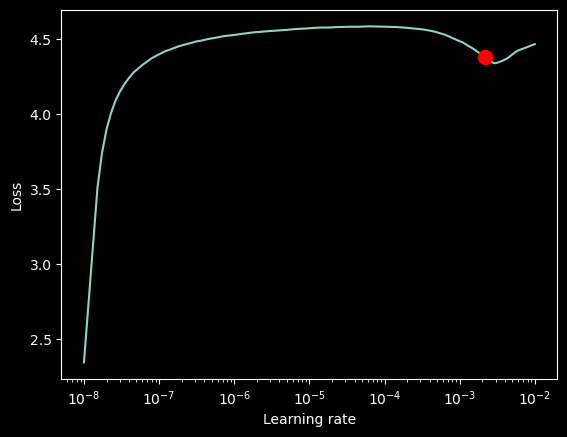

In [45]:
fig

In [12]:
# @patch
# def get_early_stop_callback(self: ClassificationTask, monitor='valid_loss', min_delta=0, patience=1, mode='min'):

In [25]:
# thunder
import torch
import thunder
# # complied_cls_task = thunder.jit(cls_task)
# # cls_task.cls_model = thunder.jit(cls_task.cls_model)
# # cls_task.cls_model.backbone = thunder.compile(cls_task.cls_model.backbone)
# cls_task.optimizer_step = thunder.jit(cls_task.optimizer_step)
# cls_task.training_step = thunder.jit(cls_task.training_step)


In [13]:
#| eval: false
# size = cls_task.cls_model.image_preprocessor.size['height']
# cls_task.example_input_array = torch.Tensor(1, cls_task.cls_model.backbone.config.num_channels, size, size)
cls_task.example_input_array.shape

torch.Size([1, 3, 224, 224])

In [51]:
torch.cuda.empty_cache()

In [26]:
#| eval: false
from namable_classify.infra import runs_path
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelSummary
trainer = L.Trainer(default_root_dir=runs_path, enable_checkpointing=True, 
                    enable_model_summary=True, 
                    # num_sanity_val_steps=2, # 防止 val 在训了好久train才发现崩溃
                    num_sanity_val_steps=0, # 防止 val 在训了好久train才发现崩溃
                    callbacks=[
                        # EarlyStopping(monitor="val_loss", mode="min")
                        EarlyStopping(monitor="val_acc1", mode="max", check_finite=True, 
                                      patience=5, 
                                      check_on_train_epoch_end=False,  # check on validation end
                                      verbose=True),
                        ModelSummary(max_depth=3),
                               ]
                    , fast_dev_run=True
                    , profiler='simple'
                    # , limit_train_batches=10, 
                    # limit_val_batches=5
                    )
trainer.fit(cls_task, datamodule=cls_task.lit_data)
# TODO 第二轮的时候，第一轮还OK的batch size就突然会崩溃，可能因为 Validation 引入了新的内存？

INFO: Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Mon 2024-12-02 05:00:56.910440

INFO     Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook   ]8;id=546678;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=273145;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside                
         interactive / notebook environments is considered experimental and unstable. Your mileage                 
         may vary.                                                                                                 

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


Mon 2024-12-02 05:00:56.918823

INFO     Trainer already configured with model summary callbacks: [<class                           ]8;id=960489;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=14723;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default                    
         `ModelSummary` callback.                                                                                  

INFO: GPU available: True (cuda), used: True


Mon 2024-12-02 05:00:56.955500

INFO     GPU available: True (cuda), used: True                                                     ]8;id=744754;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=864912;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: TPU available: False, using: 0 TPU cores


Mon 2024-12-02 05:00:56.960848

INFO     TPU available: False, using: 0 TPU cores                                                   ]8;id=641620;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=517553;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: HPU available: False, using: 0 HPUs


Mon 2024-12-02 05:00:56.965630

INFO     HPU available: False, using: 0 HPUs                                                        ]8;id=765752;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=341001;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Mon 2024-12-02 05:00:56.970531

INFO     Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and ]8;id=961564;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=595078;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         checkpointing is suppressed.                                                                              

Files already downloaded and verified
Files already downloaded and verified


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Mon 2024-12-02 05:00:59.892093

INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]                                         ]8;id=842194;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=569366;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

INFO: 
  | Name                                   | Type                         | Params | Mode  | In sizes         | Out sizes
-------------------------------------------------------------------------------------------------------------------------------
0 | cls_model                              | HuggingfaceModel             | 113 M  | train | [1, 3, 224, 224] | [1, 100] 
1 | cls_model.backbone                     | AlignedResidualWaveHighMaker | 113 M  | train | [1, 3, 224, 224] | ?        
2 | cls_model.backbone.mountain            | ViTModel                     | 86.4 M | train | [1, 3, 224, 224] | ?        
3 | cls_model.backbone.waver               | ViTModel                     | 5.6 M  | eval  | ?                | ?        
4 | cls_model.backbone.mountain_peak_hooks | ModuleList                   | 16.0 M | eval  | ?                | ?        
5 | cls_model.backbone.waver_hooks         | ModuleList                   | 10.6 M | eval  | ?                | ?        
6 | cls_mod

Mon 2024-12-02 05:01:00.436257

INFO                                                                                            ]8;id=917595;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=532614;file:///home/ycm/program_files/miniconda3/envs/fastai/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_summary.py#94\94]8;;\
           | Name                                   | Type                         | Params |                      
         Mode  | In sizes         | Out sizes                                                                      
         --------------------------------------------------------------------------------------                    
         -----------------------------------------                                                                 
         0 | cls_model                              | HuggingfaceModel             | 113 M  |                      
         train | [1, 3, 224, 224] | [1, 100]                                                                       
         1 | cls_model.backbone                     | AlignedResidualWaveHighMaker | 113 M  |                      
         train | [1, 3, 224, 224] | ?                                                                              
         2 | cls_model.backbone.mountain            | ViTModel                     | 86.4 M |                      
         train | [1, 3, 224, 224] | ?                                                                              
         3 | cls_model.backbone.waver               | ViTModel                     | 5.6 M  |                      
         eval  | ?                | ?                                                                              
         4 | cls_model.backbone.mountain_peak_hooks | ModuleList                   | 16.0 M |                      
         eval  | ?                | ?                                                                              
         5 | cls_model.backbone.waver_hooks         | ModuleList                   | 10.6 M |                      
         eval  | ?                | ?                                                                              
         6 | cls_model.head                         | Linear                       | 76.9 K |                      
         train | [1, 768]         | [1, 100]                                                                       
         7 | softmax                                | Identity                     | 0      |                      
         train | [1, 100]         | [1, 100]                                                                       
         8 | loss                                   | CrossEntropyLoss             | 0      |                      
         train | ?                | ?                                                                              
         --------------------------------------------------------------------------------------                    
         -----------------------------------------                                                                 
         26.9 M    Trainable params                                                                                
         86.4 M    Non-trainable params                                                                            
         113 M     Total params                                                                                    
         453.285   Total estimated model params size (MB)                                                          

Training: |          | 0/? [00:00<?, ?it/s]

AttributeError: optimizer_step

In [ ]:
#| eval: false
cls_task.cls_model.backbone.print_model_pretty()
cls_task.cls_model.backbone.training

root
├── embeddings (ViTEmbeddings) cls_token:[1, 1, 768] position_embeddings:[1, 197, 768]
│   └── patch_embeddings (ViTPatchEmbeddings)
│       └── projection (Conv2d) weight:[768, 3, 16, 16] bias:[768]
├── encoder (ViTEncoder)
│   └── layer (ModuleList)
│       └── 0-11(ViTLayer)
│           ├── attention (ViTAttention)
│           │   ├── attention (ViTSelfAttention)
│           │   │   └── query,key,value(Linear) weight:[768, 768] bias:[768]
│           │   └── output (ViTSelfOutput)
│           │       └── dense (Linear) weight:[768, 768] bias:[768]
│           ├── intermediate (ViTIntermediate)
│           │   └── dense (Linear) weight:[3072, 768] bias:[3072]
│           ├── output (ViTOutput)
│           │   └── dense (Linear) weight:[768, 3072] bias:[768]
│           └── layernorm_before,layernorm_after(LayerNorm) weight:[768] bias:[768]
├── layernorm (LayerNorm) weight:[768] bias:[768]
└── pooler (ViTPooler)
    └── dense (Linear) weight:[768, 768] bias:[768]

False

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()